In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import json
from fastai.conv_learner import *
from fastai.dataset import *
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.set_device(0)

In [3]:
PATH=Path('F:/Kaggle/Object_Dectection/')
list(PATH.iterdir())

[WindowsPath('F:/Kaggle/Object_Dectection/images'),
 WindowsPath('F:/Kaggle/Object_Dectection/models'),
 WindowsPath('F:/Kaggle/Object_Dectection/model_X.h5'),
 WindowsPath('F:/Kaggle/Object_Dectection/RGB.csv'),
 WindowsPath('F:/Kaggle/Object_Dectection/Summation.csv'),
 WindowsPath('F:/Kaggle/Object_Dectection/Summision_1.csv'),
 WindowsPath('F:/Kaggle/Object_Dectection/test'),
 WindowsPath('F:/Kaggle/Object_Dectection/test.csv'),
 WindowsPath('F:/Kaggle/Object_Dectection/tmp'),
 WindowsPath('F:/Kaggle/Object_Dectection/train'),
 WindowsPath('F:/Kaggle/Object_Dectection/training_set.csv'),
 WindowsPath('F:/Kaggle/Object_Dectection/Train_Aug'),
 WindowsPath('F:/Kaggle/Object_Dectection/XXX.csv')]

In [4]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle([b[0],b[2]],b[1]-b[0],b[3]-b[2], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [5]:
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))
bb_csv=PATH/'XXX.csv'
bs=48
sz=300

In [6]:
#tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=augs)
#md = ImageClassifierData.from_csv(PATH,'train',bb_csv,test_name='test',tfms=tfms, bs=bs, continuous=True)
tfm_y = TfmType.COORD
augs = []
tfms = tfms_from_stats(stats,sz,crop_type=CropType.NO,tfm_y=tfm_y,aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH,'train',bb_csv,tfms=tfms,bs=bs,continuous=True,test_name='test')

(300, 300, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


array([ 98.,  48., 208., 210.], dtype=float32)

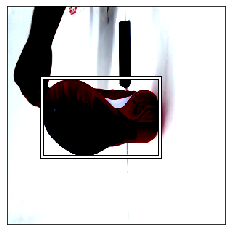

In [7]:
im=md.trn_ds[40][0].transpose([1,2,0])
print(im.shape)
ax = show_img(im)
a=md.trn_ds[40][1]
draw_rect(ax,[a[1],a[3],a[0],a[2]])
a

In [8]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x): return F.relu(self.conv(x))

In [9]:
class ConvNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([ConvLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [13]:
learn = ConvLearner.from_model_data(ConvNet2([3, 20, 40,80],4),md)

In [14]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 300, 300]),
                           ('output_shape', [-1, 20, 150, 150]),
                           ('trainable', True),
                           ('nb_params', tensor(560))])),
             ('ConvLayer-2',
              OrderedDict([('input_shape', [-1, 3, 300, 300]),
                           ('output_shape', [-1, 20, 150, 150]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 20, 150, 150]),
                           ('output_shape', [-1, 40, 75, 75]),
                           ('trainable', True),
                           ('nb_params', tensor(7240))])),
             ('ConvLayer-4',
              OrderedDict([('input_shape', [-1, 20, 150, 150]),
                           ('output_shape', [-1, 40, 75, 75]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-

In [15]:
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

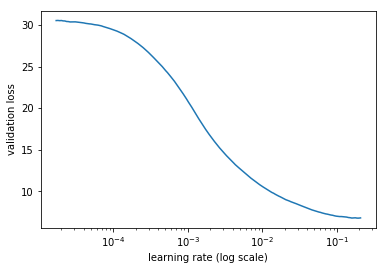

In [22]:
learn.sched.plot()

In [52]:
lr=1e-2

In [ ]:
#learn.summary()

In [26]:
wd=1e-4

In [ ]:
learn.fit(lr,1,cycle_len=2,best_save_name="asd",wds=1e-4)

  0%|                                                                                          | 0/150 [00:00<?, ?it/s]

In [ ]:
lr=4e-4

In [ ]:
learn.save('first')

In [27]:
x,y = next(iter(md.test_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

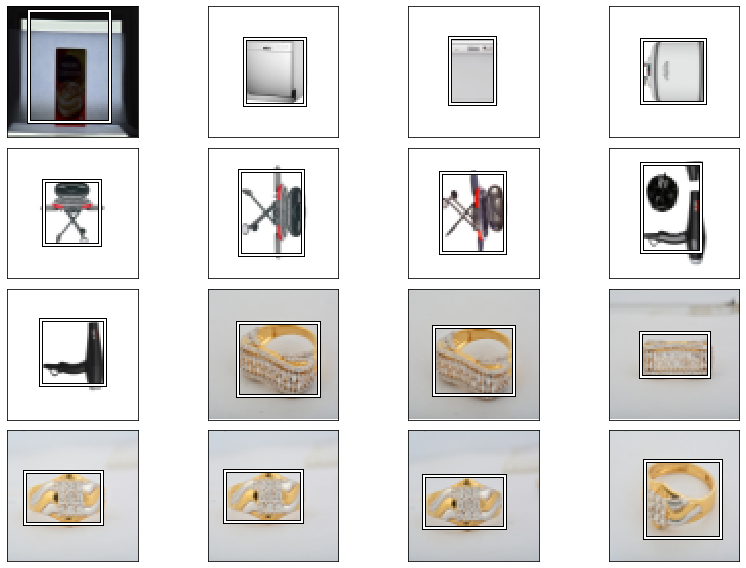

In [38]:
fig, axes = plt.subplots(4,4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.test_ds.denorm(to_np(x))[i]
    b = (preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, [b[1],b[3],b[0],b[2]])
    #print(b)
plt.tight_layout()

In [ ]:
%time learn.fit(lr,3,cycle_len=1,cycle_mult=2,wds=wd)

In [ ]:
learn.save('first_with_DA')

In [ ]:
%time learn.fit(lr,4,cycle_len=1,wds=wd)

In [ ]:
learn.save('second_with_DA')

In [ ]:
learn.lr_find(1e-6,100)

In [ ]:
learn.sched.plot()

In [ ]:
lr=2e-5
%time learn.fit(lr,1,cycle_mult=5,wds=wd)

In [ ]:
%time learn.fit(lr,1,cycle_len=4,wds=wd)
learn.save('third_with_DA')

In [ ]:
learn.load('third_with_DA')

In [ ]:
x,y = next(iter(md.trn_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

In [ ]:
fig, axes = plt.subplots(4,4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.trn_ds.denorm(to_np(x))[i]
    b = (preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, [b[1],b[3],b[0],b[2]])
    print(b)
plt.tight_layout()

In [42]:
def Create_CSV():
    Flip=[]
    for i,data in enumerate(md.test_dl):
        x,y = data
        learn.model.eval()
        preds = to_np(learn.model(VV(x)))
        print(1)
        for b in preds:
            Flip.append([b[1]*640/64,b[3]*640/64,b[0]*480/64,b[2]*480/64])
    Flip=np.array(Flip)
    for i in Flip:
        if(i[0]<0):
            i[0]=0
        if(i[1]>640):
            i[1]=640
        if(i[2]<0):
            i[2]=0
        if(i[3]>480):
            i[3]=480
    Dic={x:y for x,y in zip(md.test_ds.fnames,Flip)}
    df=pd.read_csv('F:/Kaggle/Object_Dectection/test.csv')
    FN=np.array(df['image_name'])
    Saurav=[]
    for i in FN:
        a='test\\'+i
        Saurav.append((i,Dic[a]))
    Tuple=[]
    for i in Saurav:
        x,y=i
        a=[x]+list(y)
        Tuple.append(a)   
    Out={x:y for x,y in enumerate(Tuple)}
    Final=pd.DataFrame.from_dict(Out, orient='index',columns=['image_name','x1', 'x2', 'y1', 'y2'])
    Final.to_csv('F:/Kaggle/Object_Dectection/RGB.csv',index=False)

In [ ]:
%time learn.fit(lr,8,cycle_len=4,wds=wd)
learn.save('fourth_with_DA')

In [ ]:
learn.load('fourth_with_DA')

In [ ]:
x,y = next(iter(md.test_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

In [ ]:
fig, axes = plt.subplots(4,4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.test_ds.denorm(to_np(x))[i]
    b = (preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, [b[1],b[3],b[0],b[2]])
plt.tight_layout()

In [43]:
Create_CSV()

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [39]:
df=pd.read_csv('F:/Kaggle/Object_Dectection/RGB.csv')

In [40]:
df.head()

,image_name,x1,x2,y1,y2
0,1467891670691DSC_0582.png,123.084450,640.0,133.364668,480.0
1,1475151786691DSC00560.png,427.880669,640.0,233.457456,480.0
2,1480334114405_R2A3620.png,398.257713,640.0,194.505930,480.0
3,JPEG_20160712_161047_1000606860114.png,350.664597,640.0,118.081820,480.0
4,JPEG_20160403_174522_-1137349501.png,177.748966,640.0,88.193243,480.0
